# Telco Churn Prediction

### Miguel Perez Caro

Based on the dataset, telco churn, the goal is to predict if a client will churn, which means shifting from one company to its competitor in the market. To achieve the main objective of this notebook, we get a dataset which includes the data from many customers with a target column containing if the client churned or no and several features which may help to predict if a customer is at high risk of churn.

The dataset focuses particularly in the telecom industry, where the level of competition is quite high and usually retaining a customer is much cheaper that acquiring one so the ability to predict which customer is at high risk of churn is very improtant for the companies.


Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

Loading dataset

In [3]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Exploratory Data Analysis

Change the customerId to the row index

In [4]:
df.set_index('customerID', inplace=True)

In [5]:
# Number of rows and columns
df.shape

(7043, 20)

In [6]:
# Type of the columns
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

There are many columns which will need to be transformed based on the data type. First of all, let's convert the colum TotalCharges since it is already a numeric column and has been parsed as a string so there may be something wrong.

In [7]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

Applying pandas.to_numeric to the dataframe column TotalCharges results in an error message:

ValueError: Unable to parse string " " at position 488

Then, seems that there is a space instead of a number, which cannot be parsed and is needed to add parameter errors='coerce' for convert bad non numeric values to NaN.

Since we converted those spaces to NaN, the dataset contain now null values.

In [8]:
# Null values
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

There are 11 rows which contain a null value and since the total number of rows is 7043, those rows can be deleted.

In [9]:
df.dropna(inplace=True)
df.shape

(7032, 20)

Let's get statistical information of numerical features

In [10]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


The Senior Citizen is a binarian variable with 0 or 1, telling us wheter the customer is a senior citizen or no so we don't get any information from the statistical description.

Let's plot the other 3 features

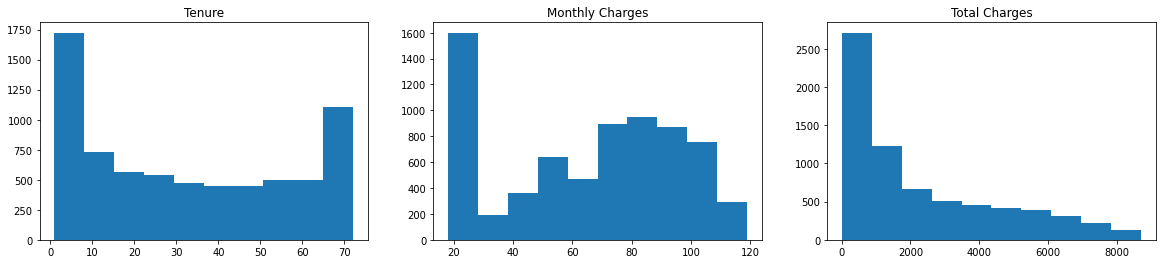

In [11]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 4)


ax[0].hist(df.tenure)
ax[1].hist(df.MonthlyCharges)
ax[2].hist(df.TotalCharges)

ax[0].set_title("Tenure")
ax[1].set_title("Monthly Charges")
ax[2].set_title("Total Charges")


plt.show()

The tenure is the number of months that the customer has been with the company and there is a high number of customers which are new, so retaining them would have a very good impact in the company. There are many customers which have been with the company for many months so it would be interesting to analyze any correlation between the target column and the tenure feature.

As for the Monthly Charges, even though the bigger bin is the first one with a small charge per month, the data is not very spreaded and there are many customers paying higher fares/rates. On the contrary, the Total Charges feature is very spreaded  and there is a small number of customer paying very high amount of money which makes the Total Charge mean being much higher.

It's also important to analyze the values from the string columns:

In [12]:
for i in df.drop(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], axis=1).columns:
    print("Unique value from {} feature are: {}\n".format(i, df[i].unique()))

Unique value from gender feature are: ['Female' 'Male']

Unique value from Partner feature are: ['Yes' 'No']

Unique value from Dependents feature are: ['No' 'Yes']

Unique value from PhoneService feature are: ['No' 'Yes']

Unique value from MultipleLines feature are: ['No phone service' 'No' 'Yes']

Unique value from InternetService feature are: ['DSL' 'Fiber optic' 'No']

Unique value from OnlineSecurity feature are: ['No' 'Yes' 'No internet service']

Unique value from OnlineBackup feature are: ['Yes' 'No' 'No internet service']

Unique value from DeviceProtection feature are: ['No' 'Yes' 'No internet service']

Unique value from TechSupport feature are: ['No' 'Yes' 'No internet service']

Unique value from StreamingTV feature are: ['No' 'Yes' 'No internet service']

Unique value from StreamingMovies feature are: ['No' 'Yes' 'No internet service']

Unique value from Contract feature are: ['Month-to-month' 'One year' 'Two year']

Unique value from PaperlessBilling feature are: ['Yes'

To start analyzing these features, we can proceed with the target:

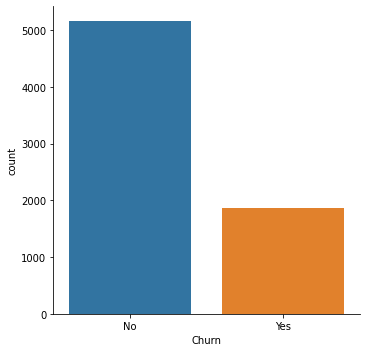

In [13]:
sns.catplot(x = "Churn", data = df, kind = "count");

The target feature is very imbalanced and it is something that maybe will need be treated.

The feature gender is not expected to have an impact on the target variable:

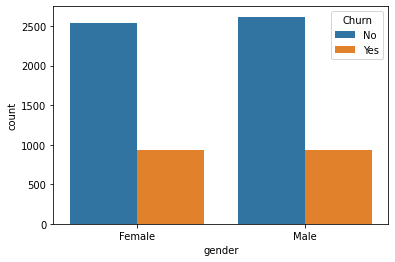

In [14]:
sns.countplot(x = 'gender', data = df, hue = "Churn");

The previous graph shows very similar churn rate for male and female so it is not going to be very relevant.

Now it is needed to compare all of the independant variables with the target. To do so, the categorical values are gonna be compared through countplots, but as a previous step, it is needed to change the unique names of the feature PaymentMethod for a better understanding of the graph.

In [15]:
payment_names = {'Electronic check': 'e-check', 'Mailed check': 'mailed-check',
                 'Bank transfer (automatic)':'bank-transfer', 'Credit card (automatic)': 'credit-card'}
df['PaymentMethod'].replace(payment_names, inplace = True)

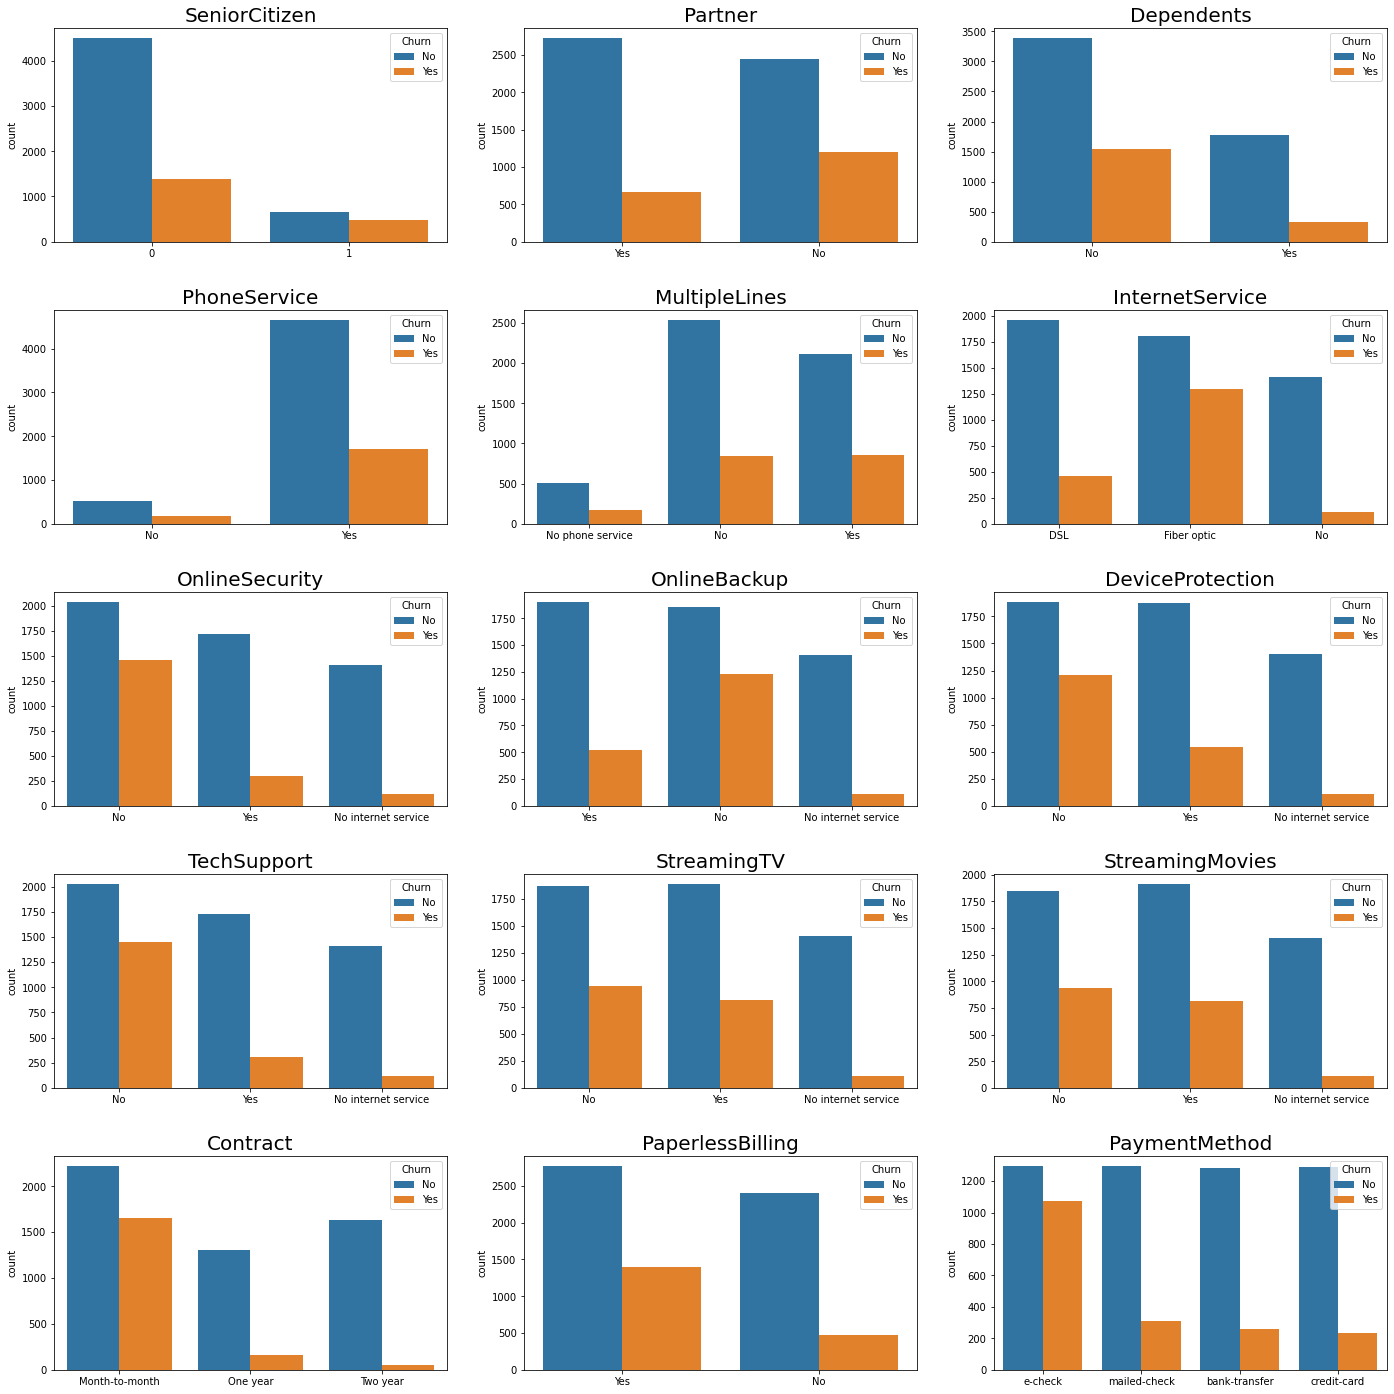

In [16]:
fig, ax = plt.subplots(5,3)
fig.set_size_inches(20, 20)

for i, j in enumerate(df.drop(['gender', 'tenure', 'Churn', 'MonthlyCharges', 'TotalCharges'], axis=1).columns):

    if i < 3:
        plot = sns.countplot(x = j, data = df, hue = "Churn", ax = ax[0, i]);
        plot.set_title(j, fontsize=20)
        plot.set(xlabel = None)

    elif i >=3 and i < 6:
        plot = sns.countplot(x = j, data = df, hue = "Churn", ax = ax[1, i-3]);
        plot.set_title(j, fontsize=20)
        plot.set(xlabel = None)
        
    elif i >= 6 and i < 9:
        plot = sns.countplot(x = j, data = df, hue = "Churn", ax = ax[2, i-6]);
        plot.set_title(j, fontsize=20)
        plot.set(xlabel = None)
        
    elif i >= 9 and i < 12:
        plot = sns.countplot(x = j, data = df, hue = "Churn", ax = ax[3, i-9]);
        plot.set_title(j, fontsize=20)
        plot.set(xlabel = None)
    
    elif i >= 12:
        plot = sns.countplot(x = j, data = df, hue = "Churn", ax = ax[4, i-12]);
        plot.set_title(j, fontsize=20)
        plot.set(xlabel = None)
            
fig.tight_layout(pad = 3.0)


Based on the previous graphs, we can obtain few insights:

* Senior Citizens seems to have a much higher churn rate (assuming senior citizens are the 1).
* People who don't have children tend to change more often that those who have.
* The contract seems to be very important but it is something expected since the customers who have one or two year contracts have much lower churn rate than those who have a month-to-month contract.
* The electronic check payment method have much higher churn rate that the other 3 possibilities.
* Based on the services purchased by the customers, those who have fiber optic tend to change very often, probably due to the variety of offers they may get from other companies. Also, customer with no internet service has very low churn rate.


[Text(0.5, 0, '')]

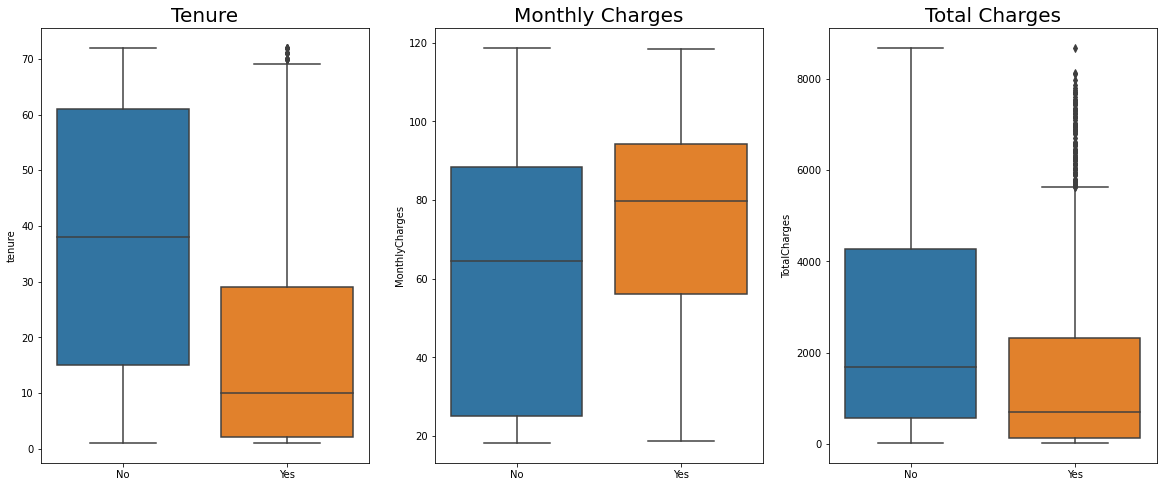

In [17]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20, 8)

plot1 = sns.boxplot(x = 'Churn', y = 'tenure', data = df, ax = ax[0]);
plot1.set_title('Tenure', fontsize=20)
plot1.set(xlabel = None)

plot2 = sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = df, ax = ax[1]);
plot2.set_title('Monthly Charges', fontsize=20)
plot2.set(xlabel = None)

plot3 = sns.boxplot(x = 'Churn', y = 'TotalCharges', data = df, ax = ax[2]);
plot3.set_title('Total Charges', fontsize=20)
plot3.set(xlabel = None)

The main insight which can be obtained from these graphs is the highest churn rate from the customers with lower tenure.

### Feature Engineering

The fist step here is to encode the labels:

In [18]:
for i in ['Partner', 'Dependents', 'Churn', 'PhoneService', 'PaperlessBilling']:
    df[i] = df[i].map({'Yes':1, 'No':0})

df['gender'] = df['gender'].map({'Female':1, 'Male':0})

df = pd.get_dummies(df, columns=['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                 'StreamingTV', 'StreamingMovies','InternetService', 'Contract', 'PaymentMethod'])

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_bank-transfer,PaymentMethod_credit-card,PaymentMethod_e-check,PaymentMethod_mailed-check
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,1,...,0,1,0,1,0,0,0,0,1,0


Next step is to normalize the numeric features which haven't been transformed which are tenure, monthly charges and total charges because some models need the features to be normalized. Since the rest of the features are 0 or 1, the technique to normalized the data is going to be Min Max Scales which rescale the values into the range [0,1].

In [19]:
minmax = MinMaxScaler()
minmax_features = minmax.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])
df_minmax = pd.DataFrame(minmax_features, columns = ['tenure', 'MonthlyCharges', 'TotalCharges'],
                         index = df.index)
df = pd.concat([df.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1), df_minmax], axis = 1)

In [20]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_bank-transfer,PaymentMethod_credit-card,PaymentMethod_e-check,PaymentMethod_mailed-check,tenure,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,0,1,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0.000000,0.115423,0.001275
5575-GNVDE,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0.464789,0.385075,0.215867
3668-QPYBK,0,0,0,0,1,1,1,1,0,0,...,1,0,0,0,0,0,1,0.014085,0.354229,0.010310
7795-CFOCW,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0.619718,0.239303,0.210241
9237-HQITU,1,0,0,0,1,1,1,1,0,0,...,1,0,0,0,0,1,0,0.014085,0.521891,0.015330


Once all features are ready, we can analyze the correlation with the target variable:

<AxesSubplot:>

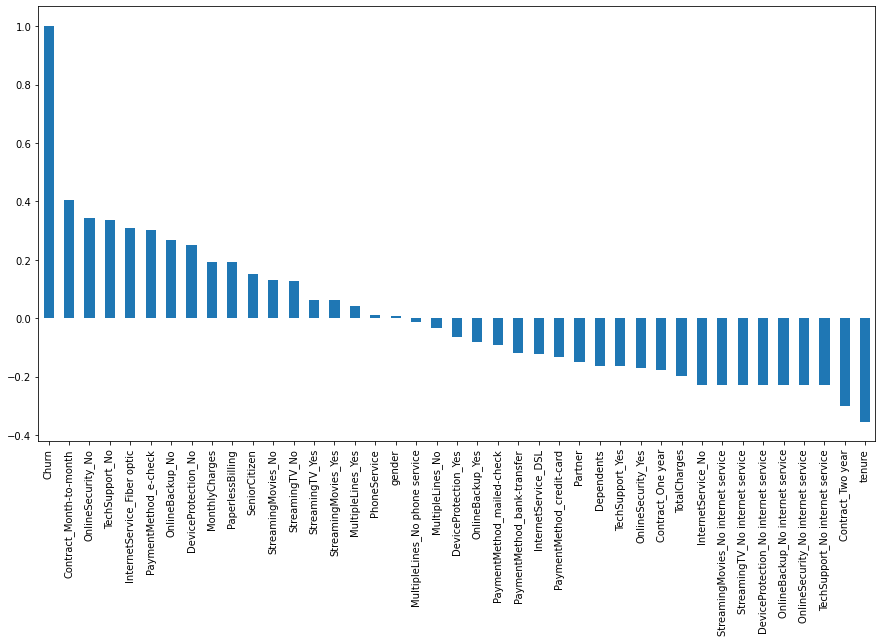

In [21]:
plt.figure(figsize=(15,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

There are few variables as gender or PhoneService which doesn't show any correlation with the target variable and probably are not going to give any value to the model and may be required to drop them.

We also see many No internet service features, so we can expect that they are gonna be highly correlated:

<AxesSubplot:>

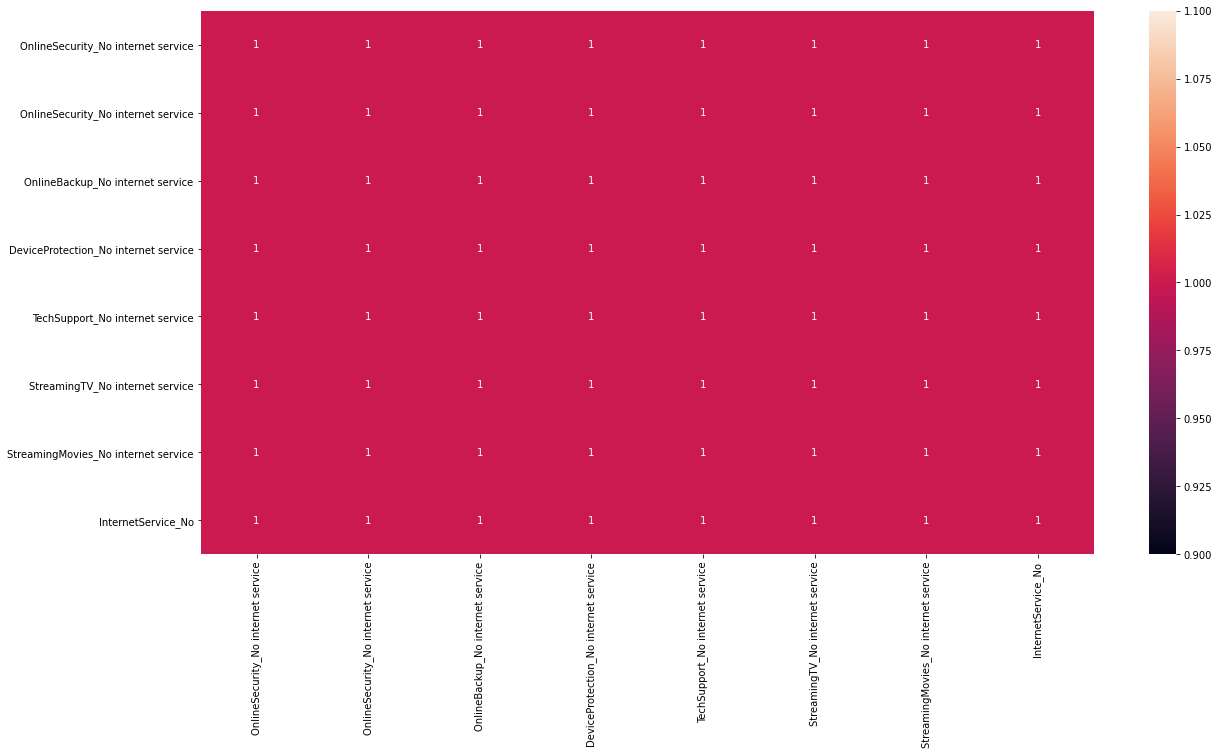

In [22]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df[['OnlineSecurity_No internet service', 'OnlineSecurity_No internet service',
                'OnlineBackup_No internet service', 'DeviceProtection_No internet service',
                'TechSupport_No internet service', 'StreamingTV_No internet service',
                'StreamingMovies_No internet service', 'InternetService_No']].corr(), annot = True, ax = ax)

All of them can be deleted except Internet Service no, and we can check the correlation for all features

<AxesSubplot:>

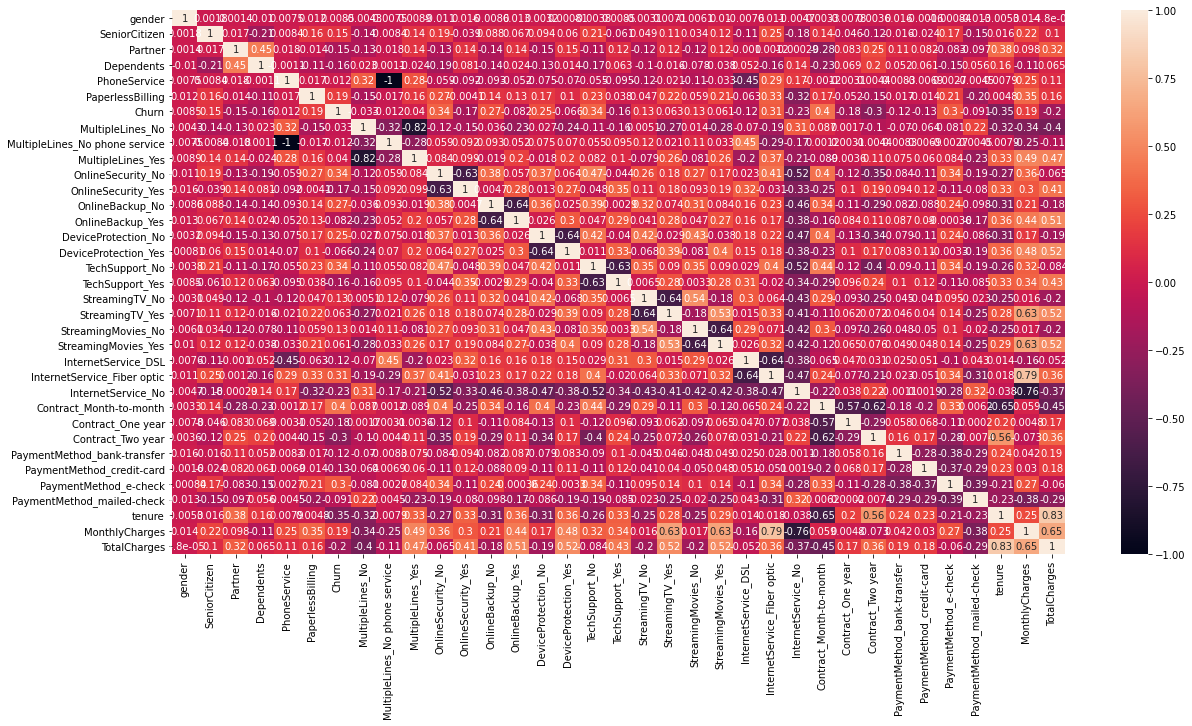

In [23]:
df = df.drop(['OnlineSecurity_No internet service', 'OnlineSecurity_No internet service',
                'OnlineBackup_No internet service', 'DeviceProtection_No internet service',
                'TechSupport_No internet service', 'StreamingTV_No internet service',
                'StreamingMovies_No internet service'], axis = 1)
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df.corr(), annot = True, ax = ax)

Due to the big amount of features is hard to get any insight from this graph, but we can conclude that PhoneService and MultipleLines_No phone service are highly correlated so we can drop this one.

In [24]:
df = df.drop('MultipleLines_No phone service', axis = 1)

### Model Evaluation

Since the preparation of the data is finsihed, we can proceed with the model evaluation. We are going to split the dataset into train and test datasets to later test different algorithms to check which can predict better the customer churn.

In [25]:
# Train-test datasets
X = df.drop('Churn', axis=1).values
y = df['Churn'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We are going to evaluate the following algorithms with several sets of parameters:

* Random Forest
* Logistic Regression
* Support Vector Machines
* XGboost

In [26]:
def models_and_parameters_definition():
    """
    Auxiliary function to define the models to try and the grid parameter search for
    cross validation
    :return: dict of {'model':'gs_model'}
    """
    rf = RandomForestClassifier()
    params_rf = {'max_depth': [10, 50, 80], # Maximum number of levels in tree
                 'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
                 'n_estimators': [600, 900, 1200]} # Number of trees in random forest
    gs_rf = GridSearchCV(rf,
                         params_rf,
                         cv=3,
                         scoring="neg_log_loss")


    log_reg = LogisticRegression()
    params_logreg = {"C": [0.01, 0.1, 1.0, 10, 100], # The C parameter controls the penality strength
                     "penalty": ['l1', 'l2', None]} # Regularization


    gs_logreg = GridSearchCV(log_reg,
                             params_logreg,
                             cv=3,
                             scoring="neg_log_loss")
    
    svc = SVC(probability=True)
    params_svc = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'C': [1, 10, 20, 50]} # It measure how important is to classify correctly every single point

    gs_svc = GridSearchCV(svc,
                          params_svc,
                          cv=3,
                          scoring="neg_log_loss")
    
    xgb = XGBClassifier(eval_metric='logloss')
    params_xgb = {'n_estimators': [10, 100, 1000],
                  'max_depth': [3,5,7],
                  'min_child_weight': [0.0, 1.0, 2.0]} # Defines the minimum sum of weights of all observations required in a child

    gs_xgb = GridSearchCV(xgb,
                          params_xgb,
                          cv=3,
                          scoring="neg_log_loss")

    grid_search_models = {"gs_rf": gs_rf,
                          "gs_logreg": gs_logreg,
                          "gs_svc": gs_svc,
                          "gs_xgb": gs_xgb}
    return grid_search_models 

In [27]:
def select_best_model(X_train, y_train, grid_search_models=False):
    """
    Function to select the best model with the best parameters
    :param grid_search_models: dictionary with all gridSearch we want to run. If it is not given to the function,
                              it runs models_and_parameters_definition function, where there are some models defined
    :param X_train: dataset of features to train the model
    :param y_train: categories to train the model
    :return:
    """
    if not grid_search_models:
        grid_search_models = models_and_parameters_definition()

    for name, grid_search in grid_search_models.items():
        print("Doing Grid Search de %s..." % name)
        grid_search.fit(X_train, y_train)

    best_score_each_gridsearch = [(model_name, grid_search.best_score_, grid_search.best_params_,
                                       str(grid_search.best_estimator_))
                                      for model_name, grid_search in grid_search_models.items()]
    
    df_best_score_each_gridsearch = pd.DataFrame(best_score_each_gridsearch,
                                                     columns=["gridSearchCV", "best_score", 
                                                              "best_params", "best_estimator"])
    
    df_sorted_best_score_each_gridsearch = (df_best_score_each_gridsearch.sort_values(by="best_score", 
                                                                                      ascending=False))
    

    
    model_summary = pd.DataFrame(df_sorted_best_score_each_gridsearch)
    best_model_name = model_summary['gridSearchCV'].values[0]
    best_model = grid_search_models.get(best_model_name)
    return best_model, model_summary, grid_search_models

Once the functions are ready, we can train the algorithms and we will get the best model, the model summary which includes the parameters and score of the best model from each algorithm, and the estimator.

In [28]:
best_model, model_summary, grid_search_models = select_best_model(X_train, y_train)

Doing Grid Search de gs_rf...
Doing Grid Search de gs_logreg...
Doing Grid Search de gs_svc...
Doing Grid Search de gs_xgb...


In [29]:
model_summary

,gridSearchCV,best_score,best_params,best_estimator
1,gs_logreg,-0.417849,"{'C': 10, 'penalty': 'l2'}","LogisticRegression(C=10, class_weight=None, du..."
0,gs_rf,-0.419059,"{'max_depth': 10, 'min_samples_split': 10, 'n_...","RandomForestClassifier(bootstrap=True, ccp_alp..."
3,gs_xgb,-0.421028,"{'max_depth': 5, 'min_child_weight': 0.0, 'n_e...","XGBClassifier(base_score=0.5, booster='gbtree'..."
2,gs_svc,-0.428752,"{'C': 1, 'kernel': 'linear'}","SVC(C=1, break_ties=False, cache_size=200, cla..."


The best model has been the logistic regression with the parameter C equal to 10 and the parameter penalty equal to l2.

Next step is to evaluate this model with the test set.

In [30]:
def model_performance_report(X, y, model):
    """
    Given a set of data and its labels returns a classification report
    :param X: dataset with features
    :param y: dataset with the label to classify
    :param model: classification model selected
    :return:
    """
    y_pred = model.predict(X)
    class_report = classification_report(y, y_pred, output_dict=True)
    cm = confusion_matrix(y_true=y, y_pred=y_pred)
    df_cm = pd.DataFrame(cm)
    accuracy = accuracy_score(y_true=y, y_pred=y_pred)
    f1 = f1_score(y_true=y, y_pred=y_pred)
    return class_report, df_cm, accuracy, f1

In [31]:
class_report, df_cm, accuracy, f1 = model_performance_report(X_test, y_test, best_model)

Let's print some of the metrics:

In [32]:
df_cm

,0,1
0,1390,172
1,237,311


In [33]:
print("The accuracy of the model is: {}".format(class_report['accuracy']))
print("The f1 score of the model is: {}".format(f1))


The accuracy of the model is: 0.8061611374407583
The f1 score of the model is: 0.6032977691561591


In [34]:
class_report= dict((i, class_report[i]) for i in ['0', '1']
                                        if i in class_report)
pd.DataFrame(class_report).T

,precision,recall,f1-score,support
0,0.854333,0.889885,0.871747,1562.0
1,0.643892,0.567518,0.603298,548.0


Looking at model results, the accuracy of the model is not bad, but due to the high imbalance of the data makes sense to take a look into the F1 score. In this case, the results are worse and around 43% of the churn customer weren't classified correctly, although the accuracy is much higher since the results from the customer who aren't labeled as churn are much better.

Finally, last step could be to try with a neural network. For these models it is recommendable to have much larger datasets to achieve better results but it is worth it to try a simple model to check the results:

In [35]:
y_train_dl = to_categorical(y_train, num_classes=2)
y_test_dl = to_categorical(y_test, num_classes=2)

model = Sequential([
    Dense(33, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train_dl, batch_size=32, epochs=100, verbose = 1)

score = model.evaluate(X_test, y_test_dl, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
154/154 [==============================] - 1s 801us/step - loss: 0.6685 - accuracy: 0.5934
Epoch 2/100
154/154 [==============================] - 0s 803us/step - loss: 0.5175 - accuracy: 0.7408
Epoch 3/100
154/154 [==============================] - 0s 805us/step - loss: 0.4808 - accuracy: 0.7482
Epoch 4/100
154/154 [==============================] - 0s 790us/step - loss: 0.4921 - accuracy: 0.7303
Epoch 5/100
154/154 [==============================] - 0s 804us/step - loss: 0.4638 - accuracy: 0.7662
Epoch 6/100
154/154 [==============================] - 0s 805us/step - loss: 0.4631 - accuracy: 0.7673
Epoch 7/100
154/154 [==============================] - 0s 765us/step - loss: 0.4685 - accuracy: 0.7619
Epoch 8/100
154/154 [==============================] - 0s 771us/step - loss: 0.4654 - accuracy: 0.7561
Epoch 9/100
154/154 [==============================] - 0s 786us/step - loss: 0.4499 - accuracy: 0.7740
Epoch 10/100
154/154 [==============================] - 0s 776us/step - l

154/154 [==============================] - 0s 647us/step - loss: 0.4116 - accuracy: 0.7945
Epoch 80/100
154/154 [==============================] - 0s 652us/step - loss: 0.4055 - accuracy: 0.8046
Epoch 81/100
154/154 [==============================] - 0s 666us/step - loss: 0.4057 - accuracy: 0.8089
Epoch 82/100
154/154 [==============================] - 0s 665us/step - loss: 0.4085 - accuracy: 0.8090
Epoch 83/100
154/154 [==============================] - 0s 655us/step - loss: 0.4101 - accuracy: 0.7992
Epoch 84/100
154/154 [==============================] - 0s 654us/step - loss: 0.4236 - accuracy: 0.7917
Epoch 85/100
154/154 [==============================] - 0s 655us/step - loss: 0.4074 - accuracy: 0.8054
Epoch 86/100
154/154 [==============================] - 0s 635us/step - loss: 0.4012 - accuracy: 0.8055
Epoch 87/100
154/154 [==============================] - 0s 639us/step - loss: 0.4134 - accuracy: 0.7960
Epoch 88/100
154/154 [==============================] - 0s 635us/step - loss:

To compare with the previous model, it is also important to get the f1 metric

In [41]:
print("The f1 score of the model is: {}".format(f1_score(y_true = y_test, 
                                                         y_pred = np.argmax(model.predict(X_test), axis = 1))))

The f1 score of the model is: 0.5631469979296067


This simple neural network model gets worse results than the logistic regression but could be probably improved with a different architecture and a parameter tuning.

The results obtained could be improved but due to a lack of time there was no possibility to try to solve some of the issue the dataset may have or try other techniques as:

* Correlation: analyze deeply the correlation between the independant variables.
* Drop variables: analyze the importance of the variables in the models generated and drop those whose importance is minimum.
* Parameter Tuning: improve the performance tunning of the models with more time to make tests.
* Neural Network: try different architectures looking for better results. Ideally, getting more data would help to improve the performance of this model.
* Imbalance dataset: would be useful to get more data from customers who has changed the company.

As a final step would be also useful to build a pipeline including the preprocessing and the model to save it and use it to predict new data.